In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

#make sure GPU is selected for runtime

print(f"GPU available: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

Mounted at /content/drive
GPU available: True
Device: cuda


In [2]:
ZIP_PATH = '/content/drive/MyDrive/colab/face_classifier/face_classifier.zip'

import zipfile
print("Extracting dataset...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('/content/')
print("dataset extracted to /content/face_classifier/")


Extracting dataset...
dataset extracted to /content/face_classifier/


In [3]:

class FaceDataset(Dataset):
    def __init__(self, csv_path, base_path='/content/face_classifier', transform=None):
        self.data = pd.read_csv(csv_path)
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.base_path, row['filename'])
        image = Image.open(img_path).convert('RGB')
        label = int(row['label'])

        if self.transform:
            image = self.transform(image)

        return image, label



In [4]:
#normalize images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


train_dataset = FaceDataset(
    '/content/face_classifier/clean_data/splits/train.csv',
    transform=transform
)
val_dataset = FaceDataset(
    '/content/face_classifier/clean_data/splits/val.csv',
    transform=transform
)

#GPU can handle batch_size=32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"train samples: {len(train_dataset)}")
print(f"val samples: {len(val_dataset)}")

train samples: 3271
val samples: 701


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#pretrained ResNet18
model = models.resnet18(pretrained=True)

#replace final fc layer for bin classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [6]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#Adam optimizer adjusts learning rates per parameter automatically
#making it great for transfer learning where different layers need
#different update rates

num_epochs = 10

print(f"Optimizer: Adam (lr=0.001)")
print(f"Epochs: {num_epochs}")

Optimizer: Adam (lr=0.001)
Epochs: 10


Epoch 1/10: 100%|██████████| 103/103 [00:13<00:00,  7.78it/s]


Epoch 1: Train Loss: 0.0512 | Train Acc: 98.14% | Val Loss: 1.1111 | Val Acc: 87.87%
best model saved (val acc: 87.87%)


Epoch 2/10: 100%|██████████| 103/103 [00:10<00:00,  9.41it/s]


Epoch 2: Train Loss: 0.0273 | Train Acc: 99.24% | Val Loss: 0.0087 | Val Acc: 99.57%
best model saved (val acc: 99.57%)


Epoch 3/10: 100%|██████████| 103/103 [00:10<00:00,  9.63it/s]


Epoch 3: Train Loss: 0.0032 | Train Acc: 99.97% | Val Loss: 0.0046 | Val Acc: 99.86%
best model saved (val acc: 99.86%)


Epoch 4/10: 100%|██████████| 103/103 [00:10<00:00,  9.73it/s]


Epoch 4: Train Loss: 0.0010 | Train Acc: 99.97% | Val Loss: 0.0059 | Val Acc: 99.71%


Epoch 5/10: 100%|██████████| 103/103 [00:10<00:00,  9.52it/s]


Epoch 5: Train Loss: 0.0002 | Train Acc: 100.00% | Val Loss: 0.0060 | Val Acc: 99.57%


Epoch 6/10: 100%|██████████| 103/103 [00:10<00:00,  9.43it/s]


Epoch 6: Train Loss: 0.0005 | Train Acc: 100.00% | Val Loss: 0.0074 | Val Acc: 99.71%


Epoch 7/10: 100%|██████████| 103/103 [00:11<00:00,  9.29it/s]


Epoch 7: Train Loss: 0.0328 | Train Acc: 98.96% | Val Loss: 0.0168 | Val Acc: 99.43%


Epoch 8/10: 100%|██████████| 103/103 [00:11<00:00,  8.98it/s]


Epoch 8: Train Loss: 0.0070 | Train Acc: 99.79% | Val Loss: 0.0133 | Val Acc: 99.57%


Epoch 9/10: 100%|██████████| 103/103 [00:11<00:00,  8.93it/s]


Epoch 9: Train Loss: 0.0028 | Train Acc: 99.94% | Val Loss: 0.0067 | Val Acc: 99.71%


Epoch 10/10: 100%|██████████| 103/103 [00:11<00:00,  9.05it/s]


Epoch 10: Train Loss: 0.0009 | Train Acc: 99.97% | Val Loss: 0.0069 | Val Acc: 99.71%

training complete: best val acc: 99.86%


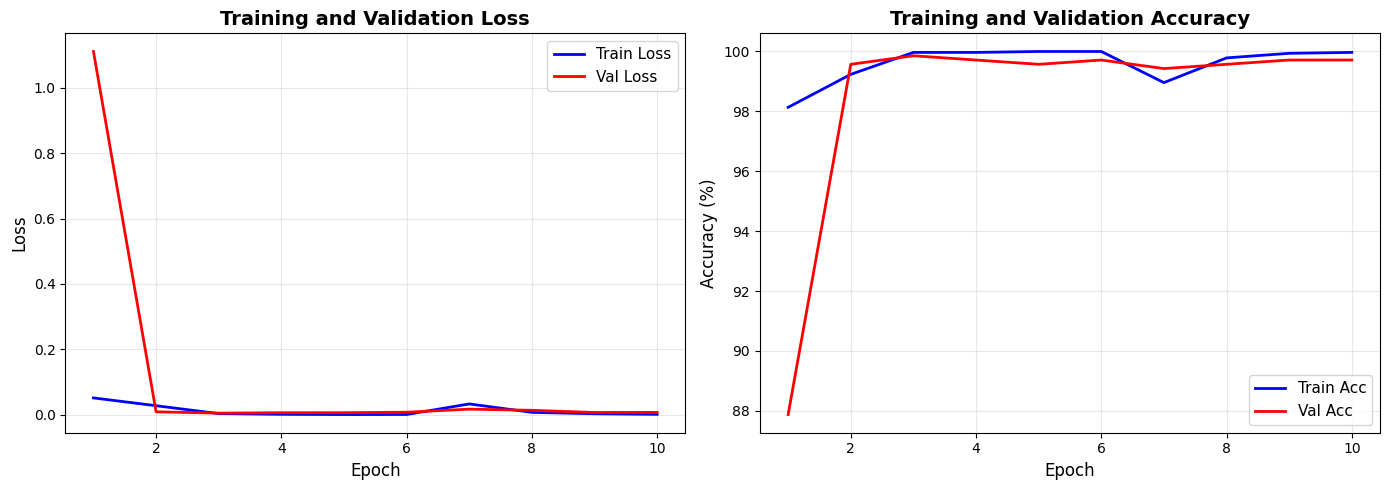

training curves saved to /content/training_curves.png


In [7]:
#tracking metrics
best_val_acc = 0.0

#to be plotted
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
#training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    train_acc = 100. * train_correct / train_total
    avg_train_loss = train_loss / len(train_loader)

    #validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_acc = 100. * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)

    print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f} | '
          f'Val Acc: {val_acc:.2f}%')

    #save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.fc.state_dict(),'/content/fc_layer_best.pth')
        print(f'best model saved (val acc: {val_acc:.2f}%)')

print(f'\ntraining complete: best val acc: {best_val_acc:.2f}%')

#plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(range(1, num_epochs+1), val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, num_epochs+1), train_accs, 'b-', label='Train Acc', linewidth=2)
ax2.plot(range(1, num_epochs+1), val_accs, 'r-', label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("training curves saved to /content/training_curves.png")

In [10]:
#saving fc layer for rust torchscript

#move model to CPU first, since rust wont be able to read it since it is gpu trained
model = model.cpu()

class FCWrapper(torch.nn.Module):
    def __init__(self, fc_layer):
        super().__init__()
        self.fc = fc_layer

    def forward(self, x):
        return self.fc(x)

fc_wrapper = FCWrapper(model.fc)
example_input = torch.randn(1, 512)  # CPU tensor!
traced_fc = torch.jit.trace(fc_wrapper, example_input)


traced_fc.save('/content/fc_layer_resnet18_cpu.pt')
import shutil
shutil.copy('/content/fc_layer_resnet18_cpu.pt',
            '/content/drive/MyDrive/fc_layer_resnet18_cpu.pt')

print("download: fc_layer_resnet18_cpu.pt")

download: fc_layer_resnet18_cpu.pt


In [9]:

#test on some practice imgages
model.eval()
test_images, test_labels = next(iter(val_loader))
test_images, test_labels = test_images.to(device), test_labels.to(device)

with torch.no_grad():
    outputs = model(test_images)
    probs = torch.softmax(outputs, dim=1)
    _, predicted = outputs.max(1)

print("\nSample Predictions:")
for i in range(min(5, len(test_images))):
    true_label = "FACE" if test_labels[i].item() == 1 else "NO FACE"
    pred_label = "FACE" if predicted[i].item() == 1 else "NO FACE"
    confidence = probs[i][predicted[i]].item() * 100
    print(f"True: {true_label} | Predicted: {pred_label} | Confidence: {confidence:.1f}%")


Sample Predictions:
True: NO FACE | Predicted: NO FACE | Confidence: 100.0%
True: FACE | Predicted: FACE | Confidence: 100.0%
True: FACE | Predicted: FACE | Confidence: 100.0%
True: NO FACE | Predicted: NO FACE | Confidence: 100.0%
True: FACE | Predicted: FACE | Confidence: 100.0%
